In [29]:
# -*- coding: utf-8 -*-
"""
2D static small-strain flat-punch problem using isoparametric FE
     _______↓↓↓↓________    
   /|___|___|___|___|___|/
   /|___|___|___|___|___|/
   /|___|___|___|___|___|/
   /|___|___|___|___|___|/
   /|___|___|___|___|___|/
   /|___|___|___|___|___|/
    ////////////////////
        
@author: Konstantinos Karapiperis
"""
import sys
import numpy as np
sys.path.insert(1,'src')
from readmesh import Mesh
from quadrature import Quadrature
from quad_element import QuadElement
from material_point import MaterialPoint
from assembler import Assembler
from solver import DistanceMinimizingSolver
from postprocessor import PostProcessor

=============================================================================<br>
Mesh data<br>
=============================================================================<br>

In [30]:
mesh = Mesh('input/nodal-coords.dat',
            'input/material-point-connectivity.dat',
            'input/essential-bcs.dat')
                 
n_nod, coord =  mesh.get_coords()
n_mat_pts, conn = mesh.get_conn()
ebcs = mesh.get_ebcs()
dim = 2   # number of spatial dimensions
n_dof = 2 # number of degrees of freedom
n_gp = 4  # number of gauss points/element

=============================================================================<br>
Distance-inducing numerical matrix<br>
=============================================================================<br>

In [31]:
E = 1e2  # Young's modulus
nu = 0.3 # Poisson's ratio
rho = 0  # density (Kg/m^3)
t = 1    # thickness

In [32]:
G = E/(2 * (1 + nu))
Ebar = E/((1+nu)*(1-2*nu))
lamda = E*nu/((1+nu)*(1-2*nu))
C = np.array([[Ebar*(1-nu), 0, 0, nu*Ebar],
              [0,           G, G,       0],
              [0,           G, G,       0],
              [nu*Ebar, 0, 0, Ebar*(1-nu)]])

=============================================================================<br>
Read material data set <br>
=============================================================================<br>
Concatenated Voigt strains and stresses in each row

In [33]:
mat_data_set = np.loadtxt('input/material-data.dat')

Random initialization of data set ids for each material point

In [34]:
data_set_idxs = np.random.choice(len(mat_data_set),size=n_mat_pts,replace=True)

=============================================================================<br>
Construct quadrature rule and isoparametric base element<br>
=============================================================================<br>

In [35]:
quadrature = Quadrature(dim,n_gp)
quad_element = QuadElement(dim,n_gp)

=============================================================================<br>
Construct elements (material points)<br>
=============================================================================<br>

In [36]:
mat_points = np.empty(n_mat_pts, dtype=object) 
for mp_idx in range(n_mat_pts):
    qp_index = mp_idx % n_gp
    mat_points[mp_idx] = MaterialPoint(mp_idx, rho, t, coord, conn[mp_idx], 
        quad_element, quadrature, qp_index, mat_data_set, C, lamda, G)

=============================================================================<br>
Assembler<br>
=============================================================================<br>

In [37]:
assembler = Assembler(mat_points, n_nod, data_set_idxs)

=============================================================================<br>
Solver<br>
=============================================================================<br>

In [38]:
num_steps = 1
max_iterations = 10
solver = DistanceMinimizingSolver(assembler, max_iterations)
displacements = np.zeros(n_nod * n_dof)

=============================================================================<br>
Force-displacement output<br>
=============================================================================<br>

In [39]:
forced_nodes = np.array(ebcs.dofs)[np.where(np.abs(ebcs.final_vals) > 0)]
top_force = np.zeros(num_steps+1)
top_disp = np.zeros(num_steps+1)

=============================================================================<br>
Solve the problem<br>
=============================================================================<br>

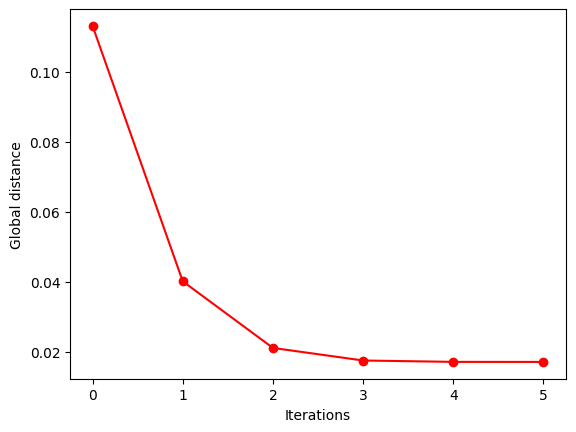

In [40]:
for step in range(num_steps):
    print('\nLoadstep', step)
    ebcs.scale(float(step+1)/num_steps)
    displacements = solver.compute_solution(ebcs, displacements, verbose=1)
    top_disp[step] = np.mean(displacements[forced_nodes])
    forces,_ = assembler.assemble_force_vectors()
    top_force[step] = np.sum(forces[forced_nodes])

=============================================================================<br>
Save force-displacement data<br>
=============================================================================<br>

In [41]:
np.savetxt("output/force-displacement.dat", np.c_[top_disp,top_force],fmt='%.3f')

=============================================================================<br>
Plot deformed mesh<br>
=============================================================================<br>

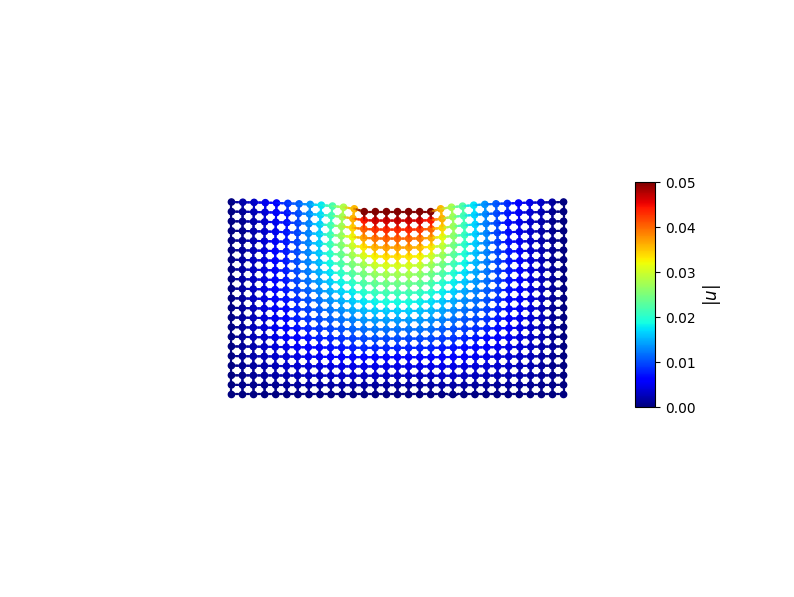

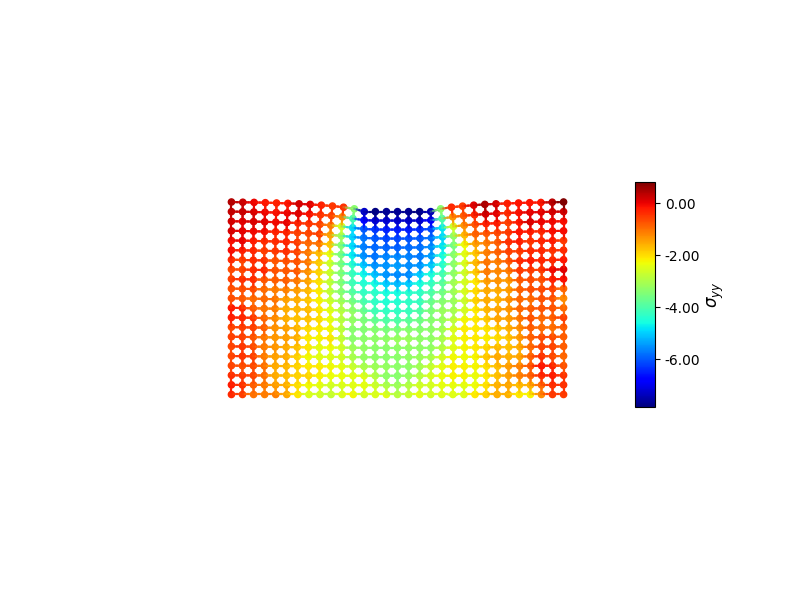

In [42]:
mag_factor = 1.
postprocessor = PostProcessor(coord, conn, mag_factor)
disp_norm = np.linalg.norm(displacements.reshape(-1,n_dof),axis=1)
postprocessor.plot_deformed_field(displacements, disp_norm, r'$|u|$')
sigma_yy = assembler.compute_node_stresses()[:,1,1]
postprocessor.plot_deformed_field(displacements, sigma_yy, r'$\sigma_{yy}$')